In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from amalearn.agent import AgentBase
from amalearn.reward import RewardBase
from amalearn.environment import EnvironmentBase

In [2]:
class MutliArmedBanditEnvironment(EnvironmentBase):
    def __init__(self, rewards, episode_max_length, id, container=None):
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(len(rewards))

        super(MutliArmedBanditEnvironment, self).__init__(action_space, state_space, id, container)
        self.arms_rewards = rewards
        self.episode_max_length = episode_max_length
        self.state = {
            'length': 0,
            'last_action': None
        }

    def calculate_reward(self, action):
        return self.arms_rewards[action].get_reward()

    def terminated(self):
        return self.state['length'] >= self.episode_max_length

    def observe(self):
        return {}

    def available_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state['length'] += 1
        self.state['last_action'] = action

    def reset(self):
        self.state['length'] = 0
        self.state['last_action'] = None

    def render(self, mode='human'):
        pass
        print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))

    def close(self):
        return
        

In [3]:
class EpsilonGreedyAgent(AgentBase):
    def __init__(self, id, environment, epsilon, status, alpha, beta, lambdaa):
        super(EpsilonGreedyAgent, self).__init__(id, environment)
        self.epsilon = epsilon
        self.status = status
        self.q_values = np.zeros(self.environment.available_actions())
        self.rewards = np.zeros(self.environment.available_actions())
        self.counts = np.zeros(self.environment.available_actions())
        self.available_actions = self.environment.available_actions()
        self.alpha = alpha
        self.beta = beta
        self.lambdaa = lambdaa

    def select_action(self):
        available_actions = self.available_actions
        eps = self.epsilon

        best_action = np.argmax(self.q_values)
        random_action = np.random.choice(available_actions)

        prob_best_action = 1 - eps + (eps / available_actions)
        prob_random_action = eps / available_actions
        sum = prob_best_action + prob_random_action #normalize
        selected_action = np.random.choice([best_action, random_action], p=[prob_best_action/sum, prob_random_action/sum])
        return selected_action

    def update(self, action, r):
        r = self.utility(r)
        self.rewards[action] += r
        self.counts[action] += 1
        self.q_values[action] = self.rewards[action] / self.counts[action]
        if self.status == "adaptive":
            self.epsilon = self.epsilon/2

    def utility(self, r):
        if r>=0:
            return r**self.alpha
        else:
            return -self.lambdaa * abs(r)**self.beta

    def take_action(self) -> (object, float, bool, object):
        action = self.select_action()
        obs, r, d, i = self.environment.step(action)
        # print(obs, r, d, i)
        self.update(action, r)
        self.environment.render()
        return obs, r, d, i

In [4]:
class UCBAgent(AgentBase):
    def __init__(self, id, environment, c, alpha, beta, lambdaa):
        super(UCBAgent, self).__init__(id, environment)
        self.c = c
        self.q_values = np.zeros(self.environment.available_actions())
        self.rewards = np.zeros(self.environment.available_actions())
        self.counts = np.zeros(self.environment.available_actions())
        self.available_actions = self.environment.available_actions()
        self.alpha = alpha
        self.beta = beta
        self.lambdaa = lambdaa

    def calculate_ucb(self, action):
        if self.counts[action] == 0:
            return np.inf
        else:
            return self.q_value[action] + self.c * np.sqrt((np.log(sum(self.counts))) / self.counts[action])

    def select_action(self):
        available_actions = np.arange(1, self.available_actions)
        ucb = [self.calculate_ucb(action) for action in available_actions]
        return np.argmax(ucb)

    def update(self, action, r):
        r = self.utility(r)
        self.rewards[action] += r
        self.counts[action] += 1
        self.q_values[action] = self.rewards[action] / self.counts[action]
    
    def utility(self, r):
        if r>=0:
            return r**self.alpha
        else:
            return -self.lambdaa * abs(r)**self.beta

    def take_action(self) -> (object, float, bool, object):
        action = self.select_action()
        obs, r, d, i = self.environment.step(action)
        # print(obs, r, d, i)
        self.update(action, r)
        self.environment.render()
        return obs, r, d, i

In [5]:
class Reward1(RewardBase):
    def __init__(self, metro_mean, metro_std, taxi_mean, taxi_std, corona_cost, time_delay_cost_per_minute, corona_prob_per_10_person):
        super(Reward1, self).__init__()
        self.metro_mean = metro_mean
        self.metro_std = metro_std
        self.taxi_mean = taxi_mean
        self.taxi_std = taxi_std
        self.corona_cost = corona_cost
        self.time_delay_cost_per_minute = time_delay_cost_per_minute
        self.corona_prob_per_10_person = corona_prob_per_10_person

    def metro_corona_cost(self):
        metro_population = np.random.normal(loc=self.metro_mean, scale=self.metro_std)
        corona_prob = metro_population/10 * self.corona_prob_per_10_person
        return corona_prob * self.corona_cost

    def metro_time_delay(self): # 6 istgah ta enghelab  #1000t per minute jarime dir residan
        time_delay = np.random.normal(loc=5, scale=2)  #minutes
        return time_delay*self.time_delay_cost_per_minute
    
    def taxi_cost(self):
        return np.random.normal(loc=self.taxi_mean, scale=self.taxi_std)
    
    def taxi_time_delay(self):
        time_delay1 = np.random.normal(loc=5, scale=2)  # 5 minutes taxi gereftan
        time_delay2 = np.random.normal(loc=10, scale=5)  # 15 minutes trafik
        return (time_delay1 + time_delay2) * self.time_delay_cost_per_minute 

    def get_reward(self):
        total_metro_cost = self.metro_corona_cost()
        taxi_cost = self.taxi_cost()
        metro_time_delay = self.metro_time_delay()
        taxi_time_delay = self.taxi_time_delay()
        return -(total_metro_cost + taxi_cost + metro_time_delay)

In [6]:
class Reward2(RewardBase):
    def __init__(self, metro_mean, metro_std, corona_cost, time_delay_cost_per_minute, corona_prob_per_10_person):
        super(Reward2, self).__init__()
        self.metro_mean = metro_mean
        self.metro_std = metro_std
        self.taxi_mean = taxi_mean
        self.taxi_std = taxi_std
        self.corona_cost = corona_cost
        self.time_delay_cost_per_minute = time_delay_cost_per_minute
        self.corona_prob_per_10_person = corona_prob_per_10_person

    def metro_corona_cost(self):
        metro_population = np.random.normal(loc=self.metro_mean, scale=self.metro_std)
        corona_prob = metro_population/10 * self.corona_prob_per_10_person
        return corona_prob * self.corona_cost * 1.5
    
    def metro_time_delay(self): # 15 istgah ta tarbiat modares
        time_delay = np.random.normal(loc=15, scale=5)  #minutes
        return time_delay*self.time_delay_cost_per_minute
    
    def get_reward(self):
        metro_corona_cost = self.metro_corona_cost()
        metro_time_delay = self.metro_time_delay()
        return -(metro_corona_cost + metro_time_delay)

In [7]:
class Reward3(RewardBase):
    def __init__(self, taxi_mean, taxi_std, corona_cost, time_delay_cost_per_minute):
        super(Reward3, self).__init__()
        self.taxi_mean = taxi_mean
        self.taxi_std = taxi_std
        self.corona_cost = corona_cost
        self.corona_prob_per_10_person = corona_prob_per_10_person
        self.time_delay_cost_per_minute = time_delay_cost_per_minute

    def taxi_cost(self):
        return np.random.normal(loc=self.taxi_mean, scale=self.taxi_std) * 3
        
    def taxi_time_delay(self): #3 ta taxi
        time_delay1 = np.random.normal(loc=5, scale=2)  # 5 minutes taxi gereftan
        time_delay2 = np.random.normal(loc=10, scale=5)  # 15 minutes trafik
        return (time_delay1 + time_delay2)*self.time_delay_cost_per_minute*3
    
    def get_reward(self):
        taxi_cost = self.taxi_cost()
        taxi_time_delay = self.taxi_time_delay()
        return -(taxi_cost+taxi_time_delay)

In [8]:
class Reward4(RewardBase):
    def __init__(self, snap_mean, snap_std, corona_cost, time_delay_cost_per_minute):
        super(Reward4, self).__init__()
        self.snap_mean = snap_mean
        self.snap_std = snap_std
        self.corona_cost = corona_cost
        self.corona_prob_per_10_person = corona_prob_per_10_person
        self.time_delay_cost_per_minute = time_delay_cost_per_minute

    def snap_cost(self):
        return np.random.normal(loc=self.snap_mean, scale=self.snap_std)

    def snap_time_delay(self): #trafik
        time_delay1 = np.random.normal(loc=5, scale=2)  # 5 minutes snap gereftan
        time_delay2 = np.random.normal(loc=10, scale=5)  # 30 minutes trafik
        return (time_delay1 + time_delay2)*self.time_delay_cost_per_minute

    def get_reward(self):
        snap_cost = self.snap_cost()
        snap_time_delay = self.snap_time_delay()
        return -(snap_cost+snap_time_delay)

In [9]:
def main_run(env, trials, status, epsilon, eps_status, alpha, beta, lambdaa):
    total_rewards = np.zeros((trials))
    env.reset()

    if status == "EpsilonGreedyAgent":
        agent = EpsilonGreedyAgent(1, env, epsilon, eps_status, alpha, beta, lambdaa)
    if status == "UCBAgent":
        agent = UCBAgent(2, env, 1, alpha, beta, lambdaa)

    for trial in range(trials):
        agent.take_action()
        total_rewards[trial] = sum(agent.rewards)/(trial+1)
    return total_rewards

In [10]:
metro_mean = 74
metro_std = 5

taxi_mean = 5000
taxi_std = 500

snap_mean = 40000
snap_std = 5000

corona_cost = 1000000
corona_prob_per_10_person = 2 * (10**-5)

time_delay_cost_per_minute = 500

trials = 300
rounds = 0

In [23]:
r1 = Reward1(metro_mean, metro_std, taxi_mean, taxi_std, corona_cost, time_delay_cost_per_minute, corona_prob_per_10_person)
r2 = Reward2(metro_mean, metro_std, corona_cost, time_delay_cost_per_minute, corona_prob_per_10_person)
r3 = Reward3(taxi_mean, taxi_std, corona_cost, time_delay_cost_per_minute)
r4 = Reward4(snap_mean, snap_std, corona_cost, time_delay_cost_per_minute)
rewards = [r1, r2, r3, r4]
env = MutliArmedBanditEnvironment(rewards, 300, '1')
mean_reward = main_run(env, trials, "EpsilonGreedyAgent", 0.9, "adaptive", 1, 2, 5)

1:	action=0
2:	action=1
3:	action=2
4:	action=3
5:	action=1
6:	action=0
7:	action=1
8:	action=1
9:	action=1
10:	action=1
11:	action=1
12:	action=1
13:	action=1
14:	action=1
15:	action=1
16:	action=1
17:	action=1
18:	action=1
19:	action=1
20:	action=1
21:	action=1
22:	action=1
23:	action=1
24:	action=1
25:	action=1
26:	action=1
27:	action=1
28:	action=1
29:	action=1
30:	action=1
31:	action=1
32:	action=0
33:	action=0
34:	action=1
35:	action=0
36:	action=0
37:	action=0
38:	action=0
39:	action=0
40:	action=0
41:	action=0
42:	action=0
43:	action=0
44:	action=0
45:	action=0
46:	action=0
47:	action=0
48:	action=0
49:	action=0
50:	action=0
51:	action=0
52:	action=0
53:	action=0
54:	action=0
55:	action=0
56:	action=0
57:	action=0
58:	action=0
59:	action=0
60:	action=0
61:	action=0
62:	action=0
63:	action=0
64:	action=0
65:	action=0
66:	action=0
67:	action=0
68:	action=0
69:	action=0
70:	action=0
71:	action=0
72:	action=0
73:	action=0
74:	action=0
75:	action=0
76:	action=0
77:	action=0
78:	acti

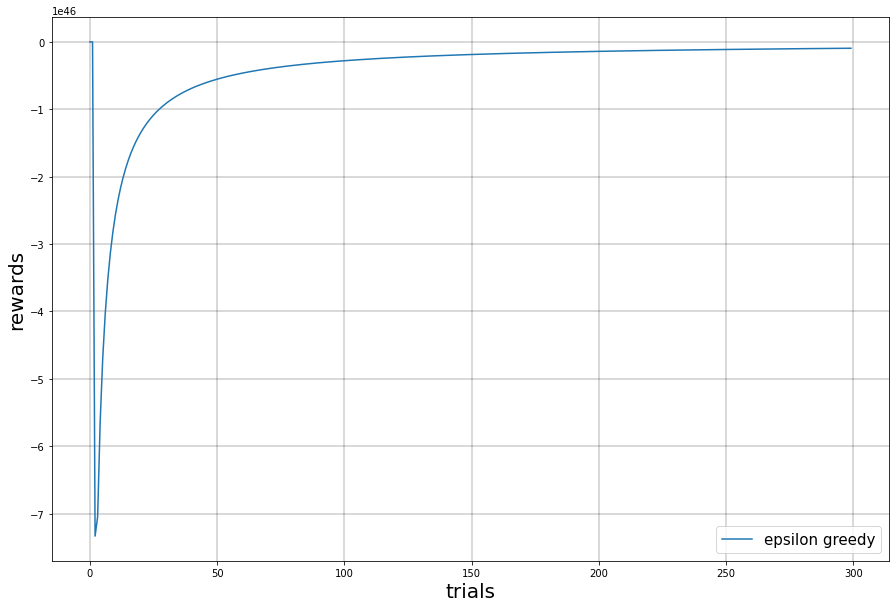

In [22]:
fig = plt.figure(figsize=(15, 10))
ax = fig.gca()
ax.set_xticks(np.arange(0, 1000, 50))
plt.plot(mean_reward, label="epsilon greedy")
plt.xlabel("trials", fontsize = 20)
plt.ylabel("rewards", fontsize = 20)
plt.legend(loc='best',fontsize = 15)
plt.grid(color = 'black',linewidth = 0.3)
plt.show()

In [1]:
import os
os.system('jupyter nbconvert --to html HW2_Q3.ipynb')

0